In [44]:
from __future__ import print_function

# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict
from IPython.display import display, HTML # used to print out pretty pandas dataframes

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru

import colorsys
def gg_color_hue(n):
    hues = np.linspace(15, 375, n)
    hsv_tuples = [(x*1.0/360.0, 0.5, 0.8) for x in hues]
    rgb_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples)
    return rgb_tuples


%matplotlib inline
plt.style.use('ggplot')

font = {'family' : 'DejaVu Sans',
        'size'   : 20}

matplotlib.rc('font', **font)

In [45]:
df = pd.read_csv(os.path.join('data','sepsis3-df.csv'))

# convert coulmns to datetime
for c in ['intime','outtime',
          'suspected_infection_time_mv','suspected_infection_time',
          'suspected_infection_time_poe', 'blood_culture_time']:
    if c in df.columns:
        if df[c].dtype == 'object':
            df[c] = pd.to_datetime(df[c])

# list of the sepsis definitions
sepsis_list = ['sepsis_angus','sepsis_martin', 'sepsis_explicit',
               'sepsis_cdc', 'sepsis_nqf', 'sepsis-3']

## add in year .. if available

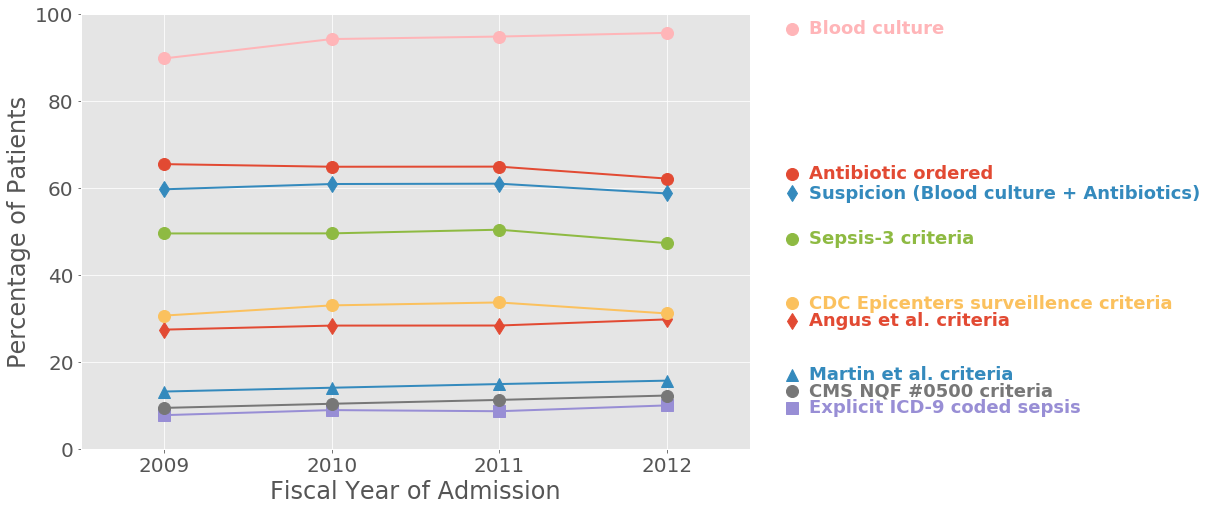

Score          	2009	2010	2011	2012
sepsis_angus   	27.4	28.3	28.3	29.8
sepsis_martin  	13.2	14.0	14.9	15.7
sepsis_explicit	7.7	8.9	8.6	10.0
sepsis_nqf     	9.4	10.4	11.2	12.2
sepsis_cdc     	30.6	33.0	33.7	31.1
sepsis-3       	49.5	49.5	50.4	47.3
blood culture  	89.8	94.2	94.8	95.6
abx_poe        	65.5	64.9	64.9	62.1
suspicion_poe  	59.7	60.9	61.0	58.7


In [50]:
if not os.path.isfile('mimiciii_fiscal_year.csv'):
    print('Cannot create plot as years are not available.')
else:
    yr = pd.read_csv('mimiciii_fiscal_year.csv')
    # set columns to lower case
    yr.columns = [x.lower() if x != 'FISCALYEAR' else 'year' for x in yr.columns]
    
    yr = yr.merge(df, how='inner', left_on='hadm_id', right_on='hadm_id')
    
    yr_keep = np.linspace(2009,2012,4)
    # create a dataframe that indicates if a patient has:
    # heart rate, blood pressure, temperature, respiration rate
    # in the first day.

    sepsis = ['sepsis_angus','sepsis_martin','sepsis_explicit',
              'sepsis_nqf','sepsis_cdc',
              'sepsis-3',
              #'septic_shock_explicit', 'severe_sepsis_explicit', 'suspicion_mv',
              'blood culture', 'abx_poe', 'suspicion_poe']


    grouped = yr.loc[np.in1d(yr['year'],yr_keep),:].groupby('year')

    plt.figure(figsize=[12,8])

    # get the x-axis from the original data - right now it's plotting against 0:NUMBER_OF_YEARS
    year = np.unique(yr['year'].values)
    Y = year.size

    # set x-axis labels to years
    #ax.set_xticks(range(Y))
    #ax.set_xticklabels(year,fontsize=14)

    pretty_labels = {'sepsis_angus': 'Angus et al. criteria',
                    'sepsis_martin': 'Martin et al. criteria',
                    'sepsis_explicit': 'Explicit ICD-9 coded sepsis',
                    'sepsis_nqf': 'CMS NQF #0500 criteria',
                    'sepsis_cdc': 'CDC Epicenters surveillence criteria',
                    'septic_shock_explicit': 'ICD-9 code 785.52 (septic shock)',
                    'severe_sepsis_explicit': 'ICD-9 code 995.92 (severe sepsis)',
                    'sofa>=2': 'SOFA >= 2',
                    'sepsis-3': 'Sepsis-3 criteria',
                    'blood culture': 'Blood culture',
                    'abx_poe': 'Antibiotic ordered',
                    'suspicion_mv': 'Blood culture + Antibiotics (IV)',
                    'suspicion_poe': 'Suspicion (Blood culture + Antibiotics)',
                    'suspicion_piv': 'Blood culture + Antibiotics (POE IV)'}
    
    # if listed here, we use a special marker
    # otherwise we just use 'o'
    marker_special = {'severe_sepsis_explicit': '^',
                      'sepsis_martin': '^',
                      'sepsis_explicit': 's',
                      'sepsis_angus': 'd',
                      'suspicion_poe': 'd'
                     }
    
    # prevent overlapping labels by changing the y_pos
    y_pos_fix = {'suspicion_poe': -1,
                'sepsis_martin': 0.4,
                'sepsis_explicit': -1.5,
                'sepsis_cdc': 1.3,
                'sepsis_angus': -1.3}
    # ===================== #
    # === PLOT THE DATA === #
    # ===================== #  
    for i, s in enumerate(sepsis):
        marker='o'
        if s in marker_special:
            marker=marker_special[s]
        p = plt.plot(grouped.apply(lambda subf: subf[s].mean()*100.0), label=pretty_labels[s],
                linewidth=2,linestyle='-',marker=marker,markersize=12)


        # Add a text label to the right end of every line
        y_pos = yr.loc[ yr['year'] == yr_keep[-1],s ].mean()*100.0
        x_pos = 2012.85
        
        if s in y_pos_fix:
            y_pos = y_pos + y_pos_fix[s]
            
        # plot the symbol
        plt.plot(x_pos-0.1, y_pos+1.0, linestyle='',
                 color=p[0].get_color(), clip_on=False,
                 marker=marker, markersize=12)
        plt.text(x_pos, y_pos, pretty_labels[s],
                 fontsize=18, fontweight='bold', color=p[0].get_color())    


    # pretty the plot
    plt.ylabel('Percentage of Patients', fontsize=24)
    #plt.legend(loc=[0.6,0.45])
    plt.xticks(yr_keep, ['{:g}'.format(x) for x in yr_keep])
    plt.ylim([0,100])
    plt.xlim([yr_keep[0]-.5,yr_keep[-1]+.5])
    plt.xlabel('Fiscal Year of Admission', fontsize=24)
    plt.savefig('SepsisOverTime.png')
    
    plt.show()
    # print table
    print('{:15s}'.format('Score'),end='')
    for i, y in enumerate(yr_keep):
        print('\t{:g}'.format(y),end='')
    print('')
    
    for i, s in enumerate(sepsis):
        print('{:15s}'.format(s),end='')
        for y in yr_keep:
                print('\t{:2.1f}'.format( np.sum(yr.loc[yr['year']==y,s])*100.0/np.sum(yr['year']==y)),end='')
        print('')

## Cronbach alpha and Kuder-Richardson Formula 20 agreement

In [ ]:
np.random.seed(21381)
# cronbach alpha for construct validity
reload(su)
print(' === Cronbach Alpha ===')
su.cronbach_alpha_table(df, ['sepsis_angus','sepsis_martin', 'sepsis_explicit','sepsis-3'])

print('')
print(' === KR20 ===')
su.kr20_table(df, ['sepsis_angus','sepsis_martin', 'sepsis_explicit','sepsis-3'])

print('Cronbach alpha is a generalization of KR20 to ordinal items.')

# Mortality: build models with different covariates

In [ ]:
# define outcome
target_header = "hospital_expire_flag"

# define the covariates to be added in the model (used for table of AUROCs)
preds_header = ['sirs','qsofa','qsofa_norx','sofa']
preds = su.calc_predictions(df, preds_header, target_header, model=None)
preds_logreg = su.calc_predictions(df, preds_header, target_header, model='logreg')


print('AUROC table for unadjusted scores:')
su.print_auc_table(preds, df[target_header].values, preds_header)
print('\n')

print('AUROC table for adjusted scores (using logistic regression):')
su.print_auc_table(preds_logreg, df[target_header].values, preds_header)
print('\n')

In [ ]:
from statsmodels.formula.api import logit
target_header = "hospital_expire_flag"
pred_header = 'sofa'
# test model on its own
auc = ru.calc_auc(df[pred_header].values, df[target_header].values, with_ci=False)
print('{} - univariable'.format(pred_header))
print('AUROC={:0.3f}'.format(auc))



# test model performance with addition of lactate
df['lactate_max_imputed'] = df['lactate_max']
df['lactate_max_imputed'].fillna(value=0, inplace=True)
formula = target_header + " ~ lactate_missing + lactate_max_imputed"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())

# test model performance with age and comorbid burden
formula  = target_header + " ~ age + elixhauser_hospital"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())


# test model performance with all above covariates
df['lactate_max_imputed'] = df['lactate_max']
df['lactate_max_imputed'].fillna(value=0, inplace=True)
formula = target_header + " ~ age + elixhauser_hospital + lactate_missing + lactate_max_imputed"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())

# Composite outcome - prediction performance

In [ ]:
# define outcome
target_header = 'composite_outcome'

# define the covariates to be added in the model (used for table of AUROCs)
preds_header = ['sirs','qsofa','qsofa_norx', 'sofa']
preds = su.calc_predictions(df, preds_header, target_header, model=None)
preds_logreg = su.calc_predictions(df, preds_header, target_header, model='logreg')


print('AUROC table for unadjusted scores:')
su.print_auc_table(preds, df[target_header].values, preds_header)
print('\n')

print('AUROC table for adjusted scores (using logistic regression):')
su.print_auc_table(preds_logreg, df[target_header].values, preds_header)
print('\n')

In [ ]:
from statsmodels.formula.api import logit
target_header = 'composite_outcome'
pred_header = 'sofa'
# test model on its own
auc = ru.calc_auc(df[pred_header].values, df[target_header].values, with_ci=False)
print('{} - univariable'.format(pred_header))
print('AUROC={:0.3f}'.format(auc))




# test model performance with addition of lactate
df['lactate_max_imputed'] = df['lactate_max']
df['lactate_max_imputed'].fillna(value=0, inplace=True)
formula = target_header + " ~ lactate_missing + lactate_max_imputed"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())

# test model performance with age and comorbid burden
formula  = target_header + " ~ age + elixhauser_hospital"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())


# test model performance with all above covariates
df['lactate_max_imputed'] = df['lactate_max']
df['lactate_max_imputed'].fillna(value=0, inplace=True)
formula = target_header + " ~ age + elixhauser_hospital + lactate_missing + lactate_max_imputed"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())

In [ ]:
print('Odds ratios for final model w/ lactate')
for p in model.params.index:
    print('{:20s} {:1.2f}'.format(p, np.exp(model.params[p])))

## Lactate groups

In [ ]:
groups = OrderedDict( [['No lactate', df['lactate_max'].isnull()],
         ['0-2', (df['lactate_max']>=0) & (df['lactate_max']<=2)],
         ['2-4', (df['lactate_max']> 2) & (df['lactate_max']<=4)],
         ['>4', (df['lactate_max']> 4) & (df['lactate_max']<=200)]] )


idxA = (df['sofa']>=2).values
strAdd = ['SOFA< 2','SOFA>=2']
x_sofa, lbl_sofa = su.create_grouped_hist(df, groups, idxA, strAdd=strAdd, targetStr='hospital_expire_flag')


idxA = (df['sofa']>=2).values
strAdd = ['SOFA< 2','SOFA>=2']
x_sofa_composite, lbl_sofa_composite = su.create_grouped_hist(df, groups, idxA, strAdd=strAdd, targetStr='composite_outcome')

plt.figure(figsize=[10,6])
xi = np.linspace(0,7,8)
plt.bar(xi+0.1,x_sofa,facecolor='b', label='SOFA',width=0.4)
plt.bar(xi+0.5,x_sofa_composite,facecolor='r',alpha=0.5,label='SOFA composite',width=0.4)
plt.xticks(np.linspace(0,7,8)+0.3, [x.replace('SOFA','').replace('No lactate','N/A') for x in lbl_sofa])
plt.legend(loc='upper left')
plt.ylabel("Hospital mortality / composite")
plt.text(7.8,-0.09,'Lactate\nSOFA')
plt.show()

In [ ]:
groups = OrderedDict( [['No lactate', df['lactate_max'].isnull()],
         ['0-2', (df['lactate_max']>=0) & (df['lactate_max']<=2)],
         ['2-4', (df['lactate_max']> 2) & (df['lactate_max']<=4)],
         ['>4', (df['lactate_max']> 4) & (df['lactate_max']<=200)]] )


idxA = (df['sofa']>=2).values
strAdd = ['SOFA< 2','SOFA>=2']
x_sofa, lbl_sofa = su.create_grouped_hist(df, groups, idxA, strAdd=strAdd, targetStr='hospital_expire_flag')


idxA = (df['sofa']>=2).values
strAdd = ['SOFA< 2','SOFA>=2']
x_sofa_composite, lbl_sofa_composite = su.create_grouped_hist(df, groups, idxA, strAdd=strAdd, targetStr='composite_outcome')

print('{:10s}\tSOFA< 2\tSOFA>=2'.format(''),end='')
print('\t\tSOFA< 2\tSOFA>=2'.format(''))
for i in range(len(lbl_sofa)/2):
    i1 = 2*i
    i2 = 2*i+1
    
    print('{:10s}\t{:2.1f}\t{:2.1f}'.format( lbl_sofa[i1].split('\n')[0], 100.0*x_sofa[i1], 100.0*x_sofa[i2] ), end='')
    print('\t\t{:2.1f}\t{:2.1f}'.format( 100.0*x_sofa_composite[i1], 100.0*x_sofa_composite[i2] ))